In [ ]:
# Imports

import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import itertools
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, silhouette_samples

warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
pd.set_option('display.width', None)

In [3]:
# Loading the MNIST Data Set 

def load_mnist_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    # Normalise images to range [-1, 1]
    X_train = X_train / 127.5 - 1
    X_test = X_test / 127.5 - 1

    # Flatten 28x28 images to 784 dimensional vectors
    features_count = np.prod(X_train.shape[1:])
    X_train_flatened = X_train.reshape(n_train, features_count)
    X_test_flatened = X_test.reshape(n_test, features_count)

    return X_train_flatened, X_test_flatened, y_train, y_test


In [ ]:
# Task 1 Code

def load_and_prepare_data(subset, subset_size):
    (X_train, y_train), (_, _) = mnist.load_data()
    n_train = X_train.shape[0]
    X_train = X_train / 127.5 - 1  
    X_train = X_train.reshape(n_train, -1) 
    if subset:
        indices = np.random.choice(n_train, subset_size, replace=False)
        X_train = X_train[indices]
        y_train = y_train[indices]
    return X_train, y_train

def apply_pca(X_train_subset):
    pca = PCA(n_components=2) 
    X_train_pca = pca.fit_transform(X_train_subset)
    return X_train_pca

def plot_pca_scatter(X_train_pca, y_train_subset):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_subset, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Digit Class')
    plt.title('PCA Projection of MNIST Dataset')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def plot_ellipses_and_centroids(X_train_pca, y_train_subset):
    # Helper function to draw confidence ellipses
    def plot_ellipse(mean, cov, colour, ax):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
        width, height = 2 * np.sqrt(5.991 * eigenvalues)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle, edgecolor=colour, fill=False, linewidth=2)
        ax.add_patch(ell)

    plt.figure(figsize=(12, 10))
    for digit in range(10):
        points = X_train_pca[y_train_subset == digit]
        mean = np.mean(points, axis=0)
        cov = np.cov(points, rowvar=False)
        colour = plt.cm.tab10(digit)
        plt.scatter(points[:, 0], points[:, 1], c=[colour], alpha=0.1, s=10)
        plt.scatter(mean[0], mean[1], c=[colour], marker='x', s=100, label=f'Digit {digit}')
        plot_ellipse(mean, cov, colour, plt.gca())
    plt.title('PCA of MNIST with Centroids and 95% Confidence Ellipse Outlines')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

def pairwise_separability(X_pca, y):
    results = []
    for d1, d2 in itertools.combinations(range(10), 2):
        idx = (y == d1) | (y == d2)
        svm = LinearSVC(max_iter=10000)
        svm.fit(X_pca[idx], y[idx])
        acc = accuracy_score(y[idx], svm.predict(X_pca[idx]))
        results.append((d1, d2, acc))
    
    # Sort by accuracy in descending order
    sorted_results = sorted(results, key=lambda x: -x[2])

    plt.figure(figsize=(10, 5))
    pairs = [f"{d1}-{d2}" for d1, d2, _ in sorted_results]
    accuracies = [acc for _, _, acc in sorted_results]
    
    plt.bar(pairs, accuracies, color='skyblue')
    plt.axhline(y=np.mean(accuracies), color='r', linestyle='--', label=f'Mean Accuracy: {np.mean(accuracies):.3f}')
    plt.ylim(0.5, 1.05)
    plt.xlabel('Digit Pairs')
    plt.ylabel('Classification Accuracy')
    plt.title('Pairwise Digit Separability using SVM on PCA Features')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.legend()
    plt.show()

def compute_distribution_stats(X_pca, y):
    stats = []
    for digit in range(10):
        points = X_pca[y == digit]
        centroid = points.mean(axis=0)
        var_pc1, var_pc2 = points.var(axis=0)
        stats.append([digit, round(centroid[0], 2), round(centroid[1], 2), round(var_pc1, 2), round(var_pc2, 2), len(points)])
    display(pd.DataFrame(stats, columns=['Digit', 'Centroid_PC1', 'Centroid_PC2', 'Var_PC1', 'Var_PC2', 'N_Samples']))

def run_task1(subset=True, subset_size=10000):
    X_train, y_train = load_and_prepare_data(subset, subset_size)
    X_train_pca = apply_pca(X_train)
    plot_pca_scatter(X_train_pca, y_train)
    plot_ellipses_and_centroids(X_train_pca, y_train)
    pairwise_separability(X_train_pca, y_train)
    compute_distribution_stats(X_train_pca, y_train)



In [ ]:
# Run Task 1

run_task1()

In [ ]:
# Task 2 Code

def predict(x, w, b):
    z = np.dot(x, w) + b
    prediction = np.sign(z)
    prediction[prediction == 0] = 1
    return prediction

def optimise(x, y, w, b, max_iter, tol, learning_rate):
    n, m = x.shape

    # Initialise weights if none provided
    if w is None:
        w = np.random.randn(m) * 0.01
    if b is None:
        b = np.random.randn() * 0.01

    iter_count = 0
    error_history = []
    error = float('inf')

    while iter_count < max_iter and error > tol:
        y_pred = predict(x, w, b)
        error = np.mean(y_pred != y)
        error_history.append(error)

        if error <= tol:
            break

        # Update weights for misclassified samples
        misclassified_indices = np.where(y_pred != y)[0]
        for i in misclassified_indices:
            w += learning_rate * y[i] * x[i]
            b += learning_rate * y[i]

        iter_count += 1

    return w, b, error_history

def evaluate_perceptron(x_train, y_train, x_test, y_test, max_iter, tol, lr):
    w, b, error_history = optimise(
        x_train, y_train,
        w=None,
        b=None,
        max_iter=max_iter,
        tol=tol,
        learning_rate=lr
    )

    # Evaluate on training set
    y_train_pred = predict(x_train, w, b)
    train_accuracy = np.mean(y_train_pred == y_train)

    # Evaluate on test set
    y_test_pred = predict(x_test, w, b)
    test_accuracy = np.mean(y_test_pred == y_test)

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'weights': w,
        'bias': b,
        'error_history': error_history
    }

def visualise_weights(w, shape, digit_pair):
    plt.figure(figsize=(12, 5))
    weight_img = w.reshape(shape)

    # Plot raw weights heatmap
    plt.subplot(1, 2, 1)
    im = plt.imshow(weight_img, cmap='viridis')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(f'Weights for {digit_pair[0]} vs {digit_pair[1]}')

    # Create composite image with red for positive weights and blue for negative
    composite = np.zeros((*shape, 3))
    pos_weights = np.copy(weight_img)
    neg_weights = np.copy(weight_img)

    pos_weights[pos_weights < 0] = 0
    neg_weights[neg_weights > 0] = 0
    neg_weights = np.abs(neg_weights)

    if pos_weights.max() > 0:
        composite[:, :, 0] = pos_weights / pos_weights.max()  # Red channel
    if neg_weights.max() > 0:
        composite[:, :, 2] = neg_weights / neg_weights.max()  # Blue channel

    plt.subplot(1, 2, 2)
    plt.imshow(composite)
    plt.title(f'Composite: (Blue={digit_pair[0]}, Red={digit_pair[1]})')

    plt.tight_layout()
    plt.show()

def prepare_binary_data(digit1, digit2, X_train, y_train, X_test, y_test):
    # Filter data to keep only the two digits and label as -1 and +1
    cond = (y_train == digit1) | (y_train == digit2)
    x_train_bin = X_train[cond]
    y_train_bin = y_train[cond].astype(float)
    y_train_bin[y_train_bin == digit1] = -1
    y_train_bin[y_train_bin == digit2] = +1

    cond_test = (y_test == digit1) | (y_test == digit2)
    x_test_bin = X_test[cond_test]
    y_test_bin = y_test[cond_test].astype(float)
    y_test_bin[y_test_bin == digit1] = -1
    y_test_bin[y_test_bin == digit2] = +1

    return x_train_bin, y_train_bin, x_test_bin, y_test_bin

def run_digit_pair_experiments(digit_pairs, X_train, y_train, X_test, y_test, max_iter, tol, lr):
    results = {}

    for (digit1, digit2) in digit_pairs:
        print(f"\n--- Perceptron for digit pair {digit1} vs {digit2} ---")

        x_train_bin, y_train_bin, x_test_bin, y_test_bin = prepare_binary_data(
            digit1, digit2, X_train, y_train, X_test, y_test
        )

        result = evaluate_perceptron(
            x_train_bin, y_train_bin,
            x_test_bin, y_test_bin,
            max_iter=max_iter, tol=tol, lr=lr
        )
        results_key = f"{digit1}_vs_{digit2}"
        results[results_key] = result

        print(f"  Training Accuracy: {result['train_accuracy']:.4f}")
        print(f"  Test Accuracy: {result['test_accuracy']:.4f}")

        plt.figure(figsize=(8, 5))
        plt.plot(result['error_history'], marker='o')
        plt.title(f'Error Curve: {digit1} vs {digit2}')
        plt.xlabel('Iteration')
        plt.ylabel('Misclassification Error')
        plt.grid(True)
        plt.show()

        visualise_weights(result['weights'], shape=(28, 28), digit_pair=(digit1, digit2))

    return results

def visualise_experiment_results(results):
    pairs = []
    train_accs = []
    test_accs = []
    iterations = []

    for pair_key, res in results.items():
        pairs.append(pair_key)
        train_accs.append(res['train_accuracy'])
        test_accs.append(res['test_accuracy'])
        iterations.append(len(res['error_history']))

    df_results = pd.DataFrame({
        'Digit Pair': pairs,
        'Train Accuracy': train_accs,
        'Test Accuracy': test_accs,
        'Iterations': iterations
    })

    df_display = df_results.copy()
    df_display['Train Accuracy'] = df_display['Train Accuracy'].round(3)
    df_display['Test Accuracy'] = df_display['Test Accuracy'].round(3)
    
    print("\n----- Perceptron Results -----")
    display(df_display)

    # Sort by test accuracy for better visualisation
    sorted_indices = np.argsort(test_accs)
    sorted_pairs = [pairs[i] for i in sorted_indices]
    sorted_train_accs = [train_accs[i] for i in sorted_indices]
    sorted_test_accs = [test_accs[i] for i in sorted_indices]
    
    # Calculate difference between train and test
    acc_diff = [train - test for train, test in zip(sorted_train_accs, sorted_test_accs)]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Bar chart of accuracies
    bar_width = 0.35
    index = np.arange(len(pairs))
    bars1 = ax1.bar(index, sorted_train_accs, bar_width, label='Train Acc', color='skyblue')
    bars2 = ax1.bar(index + bar_width, sorted_test_accs, bar_width, label='Test Acc', color='orange')

    ax1.set_xlabel('Digit Pairs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Perceptron Performance by Digit Pair')
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(sorted_pairs, rotation=45)
    ax1.set_ylim(0.5, 1.05)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0, fontsize=9)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0, fontsize=9)
    
    # Plot showing train-test accuracy gap
    bars3 = ax2.bar(index, acc_diff, bar_width*2, color=['green' if x <= 0.05 else 'red' for x in acc_diff])
    ax2.set_xlabel('Digit Pairs')
    ax2.set_ylabel('Train-Test Gap')
    ax2.set_title('Difference Between Train and Test Accuracy')
    ax2.set_xticks(index)
    ax2.set_xticklabels(sorted_pairs, rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.axhline(y=0.05, color='black', linestyle='--', alpha=0.7, label='Threshold (0.05)')
    ax2.legend()
    
    for bar in bars3:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

    return df_results

def run_task2(digit_pairs, max_iter=1000, tol=1e-3, learning_rate=0.01):
    X_train, X_test, y_train, y_test = load_mnist_data()

    results = run_digit_pair_experiments(
        digit_pairs,
        X_train,
        y_train,
        X_test,
        y_test,
        max_iter=max_iter,
        tol=tol,
        lr=learning_rate
    )

    visualise_experiment_results(results)



In [ ]:
# Run Task 2

digit_pairs = [(1, 0), (8, 3), (4, 9), (8, 7), (2, 9)]

run_task2(digit_pairs)

In [4]:
# Task 3 Code 

def create_mlp(input_shape, hidden_units, output_units):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=(input_shape,)))

    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))

    model.add(layers.Dense(output_units, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_and_evaluate_mlp(model, x_train, y_train, x_test, y_test, batch_size, epochs, verbose):
    start_time = time.time()
    
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        verbose=verbose
    )

    training_time = time.time() - start_time
    
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)

    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'history': history,
        'training_time': training_time
    }

def plot_training_curves(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def compare_mlp_architectures(architectures, x_train, y_train, x_test, y_test, epochs, batch_size, verbose):
    results = {}

    for name, hidden_layers in architectures.items():
        print(f"Training {name} with architecture {hidden_layers}...")

        model = create_mlp(input_shape=x_train.shape[1],
                           hidden_units=hidden_layers,
                           output_units=10)
        
        history_info = train_and_evaluate_mlp(
            model, x_train, y_train, x_test, y_test,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose
        )

        trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])

        results[name] = {
            'train_accuracy': history_info['train_accuracy'],
            'test_accuracy': history_info['test_accuracy'],
            'parameters': trainable_params,
            'model': model,
            'history': history_info['history'],
            'training_time': history_info['training_time']
        }

        print(f"  Train accuracy: {results[name]['train_accuracy']:.4f}")
        print(f"  Test accuracy: {results[name]['test_accuracy']:.4f}")
        print(f"  Parameters: {results[name]['parameters']:,}")
        print(f"  Training time: {results[name]['training_time']:.2f} seconds\n")
        
        plot_training_curves(history_info['history'], model_name=name)

    return results

def plot_mlp_comparison(results, architectures):
    data = {
        'MLP': [],
        'Hidden Layers': [],
        'Parameters': [],
        'Train Accuracy': [],
        'Test Accuracy': []
    }

    # Collect data for plotting
    for name, res in results.items():
        data['MLP'].append(name)
        data['Hidden Layers'].append(len(architectures[name]))
        data['Parameters'].append(res['parameters'])
        data['Train Accuracy'].append(res['train_accuracy'])
        data['Test Accuracy'].append(res['test_accuracy'])

    sorted_indices = np.argsort(data['Hidden Layers'])
    hidden_layers = np.array(data['Hidden Layers'])[sorted_indices]
    parameters = np.array(data['Parameters'])[sorted_indices]
    train_acc = np.array(data['Train Accuracy'])[sorted_indices]
    test_acc = np.array(data['Test Accuracy'])[sorted_indices]

    plt.figure(figsize=(12, 6))

    # Primary plot with accuracy vs hidden layers
    ax1 = plt.gca()
    ax1.plot(hidden_layers, train_acc, 'o-', label='Train Acc', color='blue')
    ax1.plot(hidden_layers, test_acc, 's-', label='Test Acc', color='orange')
    ax1.set_xlabel('Number of Hidden Layers (Increasing)')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(hidden_layers)  
    ax1.grid(True)
    ax1.legend()

    # Secondary X-axis for parameter count
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(hidden_layers)
    
    param_labels = [f'{p/1e6:.1f}M' for p in parameters]
    ax2.set_xticklabels(param_labels, rotation=45)
    ax2.set_xlabel('Number of Parameters')

    plt.title('Accuracy vs Depth and Parameters')
    plt.tight_layout()
    plt.show()

    # Plot all test accuracies together
    plt.figure(figsize=(12, 6))
    for name, res in results.items():
        plt.plot(res['history'].history['val_accuracy'], label=f"{name} Test")
    plt.title('Test Accuracy Across All Architectures')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Create detailed results table
    detailed_data = {
        'MLP': [],
        'Architecture': [],
        'Hidden Layers': [],
        'Parameters': [],
        'Train Accuracy': [],
        'Test Accuracy': [],
        'Train Loss': [],
        'Test Loss': [],
        'Training Time (s)': []
    }

    for name, res in results.items():
        detailed_data['MLP'].append(name)
        detailed_data['Architecture'].append(str(architectures[name]))
        detailed_data['Hidden Layers'].append(len(architectures[name]))
        detailed_data['Parameters'].append(f"{res['parameters']:,}")
        detailed_data['Train Accuracy'].append(f"{res['train_accuracy']:.4f}")
        detailed_data['Test Accuracy'].append(f"{res['test_accuracy']:.4f}")
        detailed_data['Train Loss'].append(f"{res['history'].history['loss'][-1]:.4f}")
        detailed_data['Test Loss'].append(f"{res['history'].history['val_loss'][-1]:.4f}")
        detailed_data['Training Time (s)'].append(f"{res['training_time']:.2f}")

    detailed_df = pd.DataFrame(detailed_data)

    return detailed_df

def run_task3(mlp_architectures, epochs, batch_size=50):
    X_train, X_test, y_train, y_test = load_mnist_data()

    # Convert labels to one-hot
    y_train_one_hot = keras.utils.to_categorical(y_train, 10)
    y_test_one_hot = keras.utils.to_categorical(y_test, 10)

    # Sample subset for faster training
    indices = np.random.choice(len(X_train), 10000, replace=False)
    X_train = X_train[indices]
    y_train_one_hot = y_train_one_hot[indices]

    comparison_results = compare_mlp_architectures(
        mlp_architectures,
        X_train,
        y_train_one_hot,
        X_test,
        y_test_one_hot,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    detailed_df = plot_mlp_comparison(comparison_results, mlp_architectures)
    
    print("\nComparison of All MLP Architectures:")
    display(detailed_df)

    return detailed_df


Training MLP-1 with architecture [1000, 1000]...


/Users/leon/Library/Caches/pypoetry/virtualenvs/msc-ai-yPHgmFUp-py3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  Train accuracy: 0.9857
  Test accuracy: 0.9514
  Parameters: 1,796,010
  Training time: 43.66 seconds



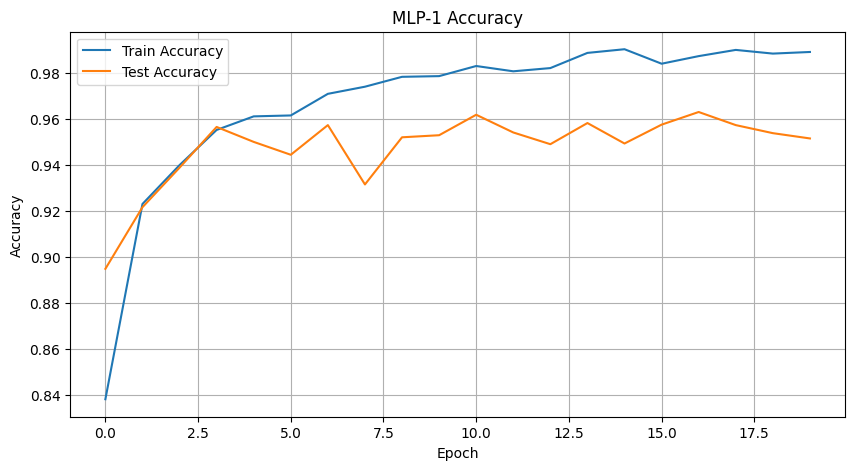

Training MLP-2 with architecture [1000, 1000, 1000]...
  Train accuracy: 0.9848
  Test accuracy: 0.9470
  Parameters: 2,797,010
  Training time: 68.85 seconds



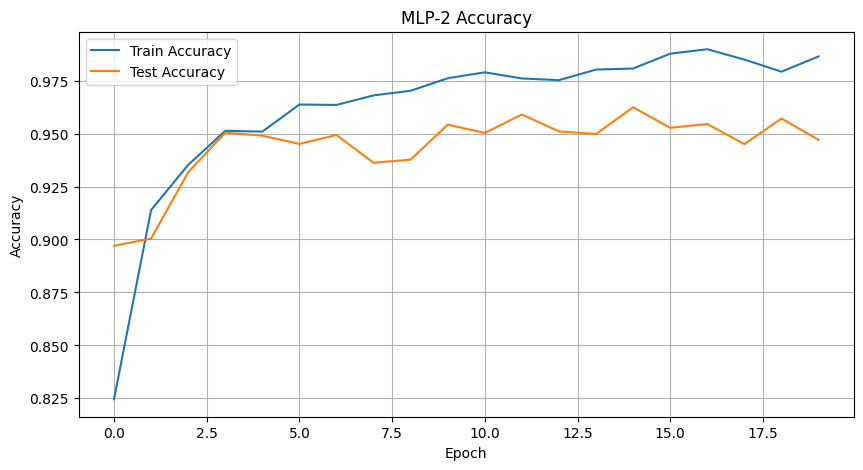

Training MLP-3 with architecture [1000, 1000, 1000, 1000, 1000]...
  Train accuracy: 0.9853
  Test accuracy: 0.9539
  Parameters: 4,799,010
  Training time: 108.42 seconds



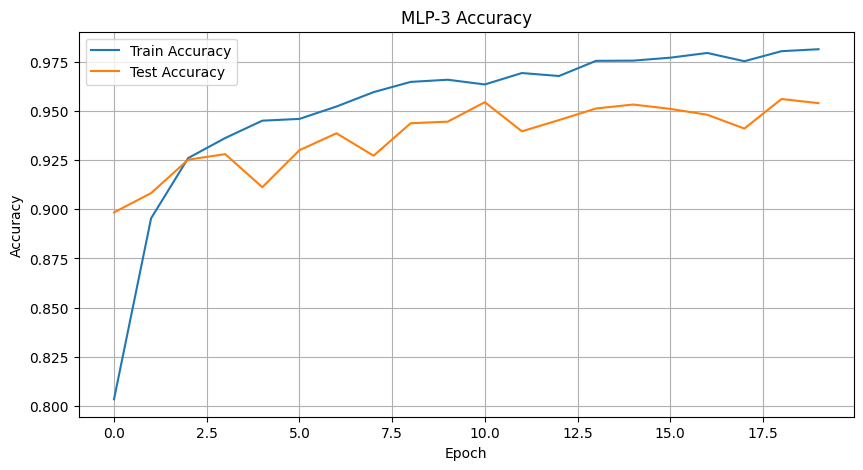

Training MLP-4 with architecture [500, 500, 500, 500, 500, 500, 500]...
  Train accuracy: 0.9779
  Test accuracy: 0.9472
  Parameters: 1,900,510
  Training time: 89.85 seconds



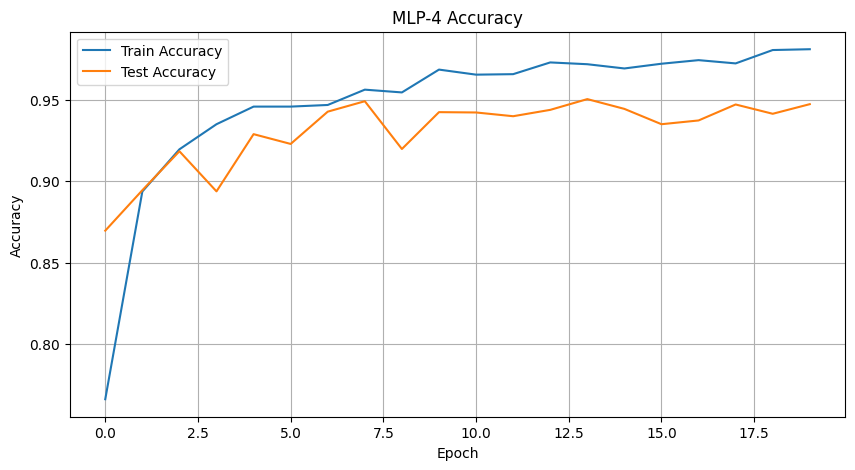

Training MLP-5 with architecture [500, 500, 500, 500, 500, 500, 500, 500, 500]...
  Train accuracy: 0.9874
  Test accuracy: 0.9584
  Parameters: 2,401,510
  Training time: 107.40 seconds



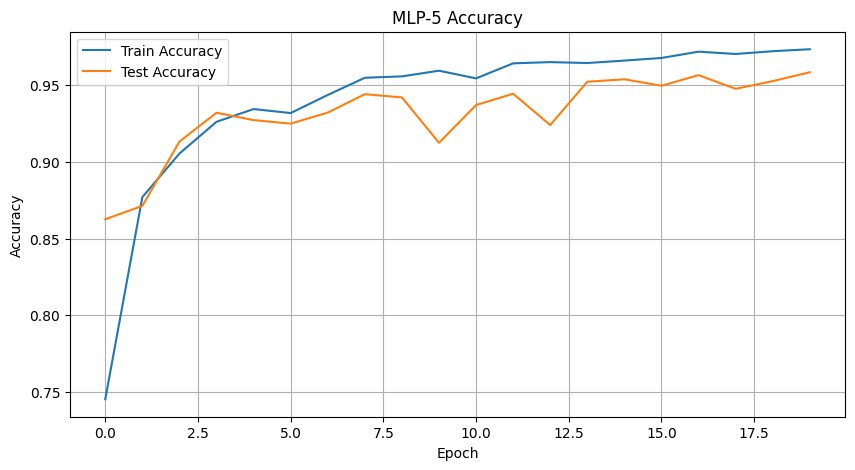

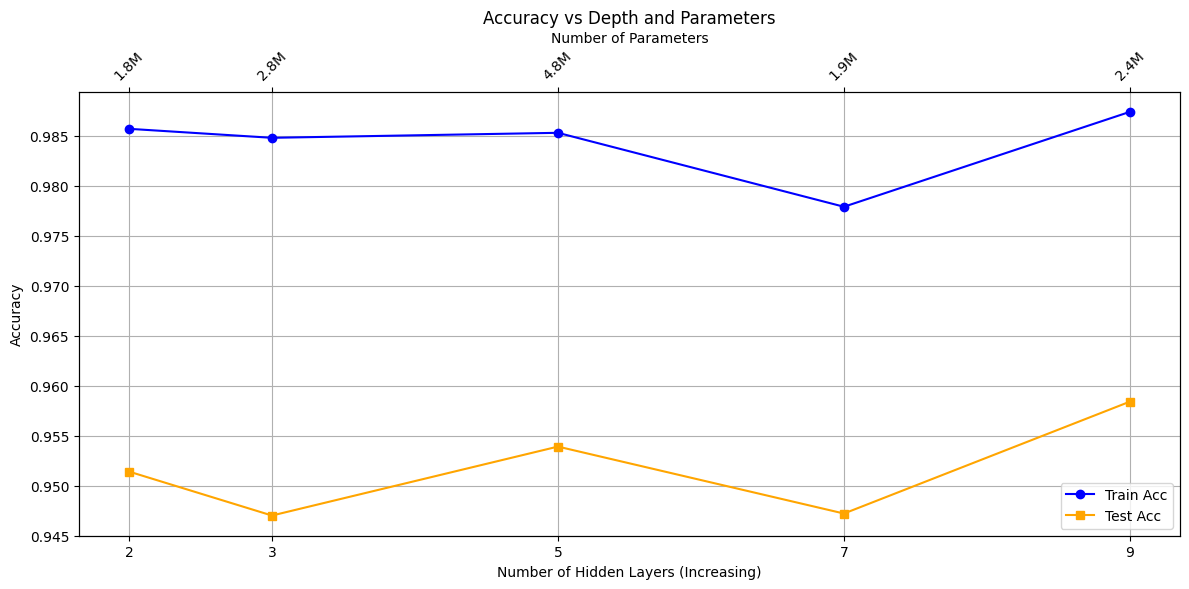

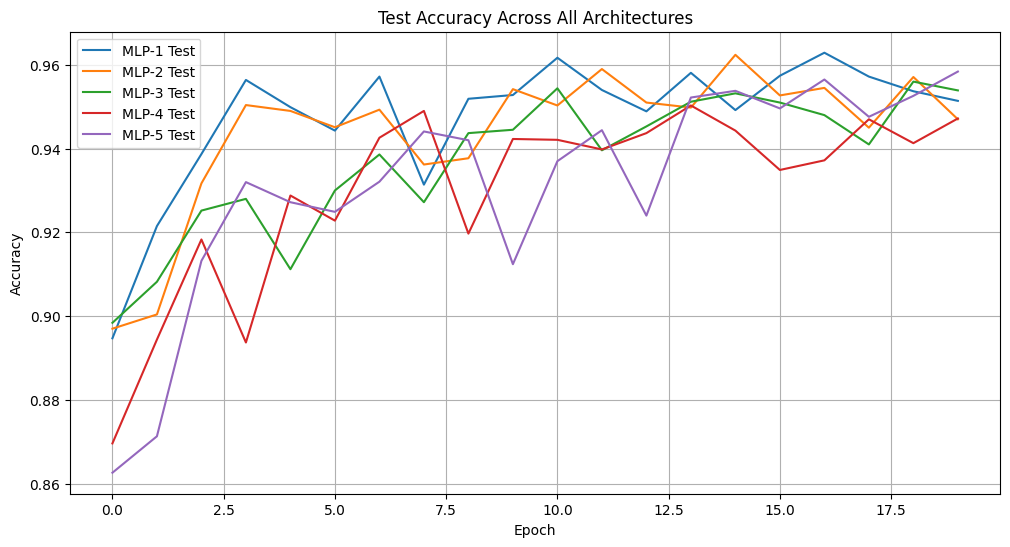


Comparison of All MLP Architectures:


,MLP,Architecture,Hidden Layers,Parameters,Train Accuracy,Test Accuracy,Train Loss,Test Loss,Training Time (s)
0,MLP-1,"[1000, 1000]",2,"1,796,010",0.9857,0.9514,0.0319,0.2523,43.66
1,MLP-2,"[1000, 1000, 1000]",3,"2,797,010",0.9848,0.9470,0.0399,0.2514,68.85
2,MLP-3,"[1000, 1000, 1000, 1000, 1000]",5,"4,799,010",0.9853,0.9539,0.0650,0.2159,108.42
3,MLP-4,"[500, 500, 500, 500, 500, 500, 500]",7,"1,900,510",0.9779,0.9472,0.0620,0.2426,89.85
4,MLP-5,"[500, 500, 500, 500, 500, 500, 500, 500, 500]",9,"2,401,510",0.9874,0.9584,0.1025,0.2122,107.40


In [5]:
# Run Task 3

mlp_architectures = {
    'MLP-1': [1000, 1000],
    'MLP-2': [1000, 1000, 1000],
    'MLP-3': [1000, 1000, 1000, 1000, 1000],
    'MLP-4': [500, 500, 500, 500, 500, 500, 500],
    'MLP-5': [500, 500, 500, 500, 500, 500, 500, 500, 500]
}

mlp_df = run_task3(mlp_architectures, epochs=20)

In [6]:
# Task 4 Code

def prepare_cnn_data():
    X_train_flattened, X_test_flattened, y_train, y_test = load_mnist_data()

    n_train = len(y_train)
    n_test = len(y_test)

    # Reshape from flattened back to image format and rescale to [0,1]
    x_train = ((X_train_flattened.reshape((n_train, 28, 28, 1))) + 1) / 2
    x_test = ((X_test_flattened.reshape((n_test, 28, 28, 1))) + 1) / 2

    # One-hot encode labels
    y_train_oh = tf.keras.utils.to_categorical(y_train, 10)
    y_test_oh = tf.keras.utils.to_categorical(y_test, 10)

    return x_train, y_train_oh, x_test, y_test_oh

def create_cnn(input_shape, filters, output_units):
    model = Sequential()
    
    # First convolutional layer - use Input layer instead of input_shape parameter
    model.add(Input(shape=input_shape))
    model.add(Conv2D(filters[0], kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu'))

    # Subsequent convolutional layers with stride=2
    for f in filters[1:]:
        model.add(Conv2D(f, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))

    model.add(Flatten())
    model.add(Dense(output_units, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_cnn_model(model, x_train, y_train, x_test, y_test, batch_size, epochs, verbose):
    start_time = time.time()
    
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        verbose=verbose
    )
    
    training_time = time.time() - start_time

    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    return {
        'model': model,
        'history': history,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'training_time': training_time
    }

def plot_cnn_results(history, name, architecture):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'{name}: Accuracy - Architecture {architecture}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'{name}: Loss - Architecture {architecture}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def create_and_train_cnn(name, filters, x_train, y_train, x_test, y_test, batch_size, epochs):
    # Clear previous models from memory
    tf.keras.backend.clear_session()

    model = create_cnn(input_shape=x_train.shape[1:], filters=filters, output_units=10)
    model._name = name
    result = train_cnn_model(model, x_train, y_train, x_test, y_test, batch_size=batch_size, epochs=epochs, verbose=0)

    # Count trainable parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])

    result.update({
        'name': name,
        'parameters': trainable_params
    })
    return result

def compare_architectures(architectures, x_train, y_train, x_test, y_test, batch_size, epochs):
    results = {}
    base_model = None
    for name, filters in architectures.items():
        print(f"\nTraining {name} with filters {filters} ...")
        results[name] = create_and_train_cnn(
            name, filters, x_train, y_train, x_test, y_test, batch_size, epochs
        )
        print(f"  -> Train accuracy: {results[name]['train_accuracy']:.4f}")
        print(f"  -> Test accuracy:  {results[name]['test_accuracy']:.4f}")
        print(f"  -> Parameters:    {results[name]['parameters']:,}")
        print(f"  -> Training time: {results[name]['training_time']:.2f} seconds\n")
        
        plot_cnn_results(results[name]['history'], name, str(filters))

        if name == 'CNN-1':
            base_model = results[name]['model']

    return results, base_model

def plot_accuracy_by_model_size(results, architectures):
    # Extract data from results
    cnn_names = list(results.keys())
    test_acc = [results[name]['test_accuracy'] for name in cnn_names]
    train_acc = [results[name]['train_accuracy'] for name in cnn_names]
    parameters = [results[name]['parameters'] for name in cnn_names]
    training_times = [results[name]['training_time'] / 10 for name in cnn_names]  # Time per epoch
    
    # Sort by test accuracy (descending)
    sorted_indices = np.argsort(test_acc)[::-1]
    cnn_names_sorted = [cnn_names[i] for i in sorted_indices]
    test_acc_sorted = [test_acc[i] for i in sorted_indices]
    train_acc_sorted = [train_acc[i] for i in sorted_indices]
    parameters_sorted = [parameters[i] for i in sorted_indices]
    training_times_sorted = [training_times[i] for i in sorted_indices]
    
    # Create bubble scatter plot
    plt.figure(figsize=(10, 6))
    
    # Calculate bubble sizes based on parameters
    size_factor = 300
    bubble_sizes = [p/np.max(parameters_sorted)*size_factor for p in parameters_sorted]
    
    scatter = plt.scatter(training_times_sorted, test_acc_sorted, s=bubble_sizes, 
                         alpha=0.7, c='blue', edgecolor='black')
    
    # Add model labels
    for i, txt in enumerate(cnn_names_sorted):
        plt.annotate(txt, (training_times_sorted[i], test_acc_sorted[i]), 
                    xytext=(5, 0), textcoords='offset points', fontsize=9)
    
    plt.title('CNN Model Comparison: Accuracy vs Training Time')
    plt.xlabel('Training Time per Epoch (seconds)')
    plt.ylabel('Test Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.text(0.5, -0.15, "Note: Bubble size represents number of parameters", 
            ha="center", transform=plt.gca().transAxes, fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_comparison(results, architectures):
    results_table = {
        'CNN': [],
        'Architecture': [],
        'Layers': [],
        'Parameters': [],
        'Train Accuracy': [],
        'Test Accuracy': [],
        'Training Time (s)': []
    }

    for name, result in results.items():
        results_table['CNN'].append(name)
        results_table['Architecture'].append(str(architectures[name]))
        results_table['Layers'].append(len(architectures[name]))
        results_table['Parameters'].append(result['parameters'])
        results_table['Train Accuracy'].append(result['train_accuracy'])
        results_table['Test Accuracy'].append(result['test_accuracy'])
        results_table['Training Time (s)'].append(result['training_time'])

    # Plot accuracy by model size
    plot_accuracy_by_model_size(results, architectures)
    
    # Plot all training histories on a single plot
    plt.figure(figsize=(12, 6))
    for name in results.keys():
        plt.plot(results[name]['history'].history['val_accuracy'], 
                 label=f"{name} - {architectures[name]}")
    plt.title('Test Accuracy Across All CNN Architectures')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    summary_df = pd.DataFrame({
        'CNN': results_table['CNN'],
        'Architecture': results_table['Architecture'],
        'Layers': results_table['Layers'],
        'Parameters': [f"{p:,}" for p in results_table['Parameters']],
        'Train Accuracy': [f"{acc:.4f}" for acc in results_table['Train Accuracy']],
        'Test Accuracy': [f"{acc:.4f}" for acc in results_table['Test Accuracy']],
        'Training Time (s)': [f"{t:.2f}" for t in results_table['Training Time (s)']]
    })
    
    print("\nCNN Architecture Comparison Summary:")
    display(summary_df)

    return summary_df

def table_mlp_cnn_comparison(df1, df2):
    df1 = df1[['MLP', 'Test Accuracy', 'Parameters', 'Training Time (s)']]
    df2 = df2[['CNN', 'Test Accuracy', 'Parameters', 'Training Time (s)']]

    df1['Epochs'] = 20
    df2['Epochs'] = 10

    df1['Epoch Train Time (s)'] = df1['Training Time (s)'].apply(lambda x: float(x)) / df1['Epochs']
    df2['Epoch Train Time (s)'] = df2['Training Time (s)'].apply(lambda x: float(x)) / df2['Epochs']

    df1['Parameters'] = df1['Parameters'].apply(lambda x: int(x.replace(',', '')))
    df2['Parameters'] = df2['Parameters'].apply(lambda x: int(x.replace(',', '')))

    df1['Parameters'] = df1['Parameters'].apply(lambda x: f"{x:,}")
    df2['Parameters'] = df2['Parameters'].apply(lambda x: f"{x:,}")

    df1['Epoch Train Time (s) / 1m param'] = round(df1['Epoch Train Time (s)'] / (df1['Parameters'].apply(lambda x: int(x.replace(',', ''))) / 1000000), 2)
    df2['Epoch Train Time (s) / 1m param'] = round(df2['Epoch Train Time (s)'] / (df2['Parameters'].apply(lambda x: int(x.replace(',', ''))) / 1000000), 2)

    df1.rename(columns={'MLP': 'MLP Architecture', 'Test Accuracy': 'MLP Test Accuracy', 'Parameters': 'MLP Parameters', 'Training Time (s)': 'MLP Training Time (s)-MLP', 'MLP Epoch Train Time (s)': 'Epoch Train Time (s)-MLP', 'Epoch Train Time (s) / 1m param': 'MLP Epoch Train Time (s) / 1m param-MLP'}, inplace=True)
    df2.rename(columns={'CNN': 'CNN Architecture', 'Test Accuracy': 'CNN Test Accuracy', 'Parameters': 'CNN Parameters', 'Training Time (s)': 'CNN Training Time (s)-CNN', 'CNN Epoch Train Time (s)': 'Epoch Train Time (s)-CNN', 'Epoch Train Time (s) / 1m param': 'CNN Epoch Train Time (s) / 1m param-CNN'}, inplace=True)

    df = pd.concat([df1, df2], axis=1)

    print("\nMLP and CNN Comparison Table:")
    display(df)
    print("\n")

    return df1, df2

def plot_mlp_cnn_comparison(df1, df2):
    mlp_models = df1['MLP Architecture'].tolist()
    cnn_models = df2['CNN Architecture'].tolist()
    mlp_accuracy = df1['MLP Test Accuracy'].astype(float).tolist()
    cnn_accuracy = df2['CNN Test Accuracy'].astype(float).tolist()
    mlp_params = [int(param.replace(',', '')) for param in df1['MLP Parameters'].tolist()]
    cnn_params = [int(param.replace(',', '')) for param in df2['CNN Parameters'].tolist()]
    mlp_epoch_time = df1['Epoch Train Time (s)'].tolist()
    cnn_epoch_time = df2['Epoch Train Time (s)'].tolist()

    # Combined plot: Efficiency and Speed comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Left plot: Accuracy per parameter (efficiency)
    efficiency_mlp = [acc/(param/1_000_000) for acc, param in zip(mlp_accuracy, mlp_params)]
    efficiency_cnn = [acc/(param/1_000_000) for acc, param in zip(cnn_accuracy, cnn_params)]

    x = np.arange(len(mlp_models))
    width = 0.35

    ax1.bar(x - width/2, efficiency_mlp, width, label='MLP', color='blue')
    ax1.bar(x + width/2, efficiency_cnn, width, label='CNN', color='red')
    ax1.set_xlabel('Model Index')
    ax1.set_ylabel('Accuracy per Million Parameters')
    ax1.set_title('Model Efficiency')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{i+1}' for i in range(len(mlp_models))])
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)

    # Right plot: Accuracy vs Training Time
    size_factor = 300
    mlp_size = [p/np.max(mlp_params)*size_factor for p in mlp_params]
    cnn_size = [p/np.max(cnn_params)*size_factor for p in cnn_params]

    scatter1 = ax2.scatter(mlp_epoch_time, mlp_accuracy, s=mlp_size, alpha=0.7, 
                        label='MLP', color='blue', edgecolor='black')
    scatter2 = ax2.scatter(cnn_epoch_time, cnn_accuracy, s=cnn_size, alpha=0.7, 
                        label='CNN', color='red', edgecolor='black')

    # Add model labels
    for i, txt in enumerate(mlp_models):
        ax2.annotate(txt, (mlp_epoch_time[i], mlp_accuracy[i]), 
                    xytext=(5, 0), textcoords='offset points', fontsize=8)
    for i, txt in enumerate(cnn_models):
        ax2.annotate(txt, (cnn_epoch_time[i], cnn_accuracy[i]), 
                    xytext=(5, 0), textcoords='offset points', fontsize=8)

    ax2.set_xlabel('Training Time per Epoch (seconds)')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Accuracy vs Training Time')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    ax2.text(0.5, -0.2, "Note: Marker size represents number of parameters", 
            ha="center", transform=ax2.transAxes, fontsize=8)

    plt.tight_layout()
    plt.show()

def run_task4(cnn_architectures, epochs, batch_size=50):
    x_train, y_train, x_test, y_test = prepare_cnn_data()

    results, base_model = compare_architectures(cnn_architectures,
                                                x_train, y_train,
                                                x_test, y_test,
                                                batch_size=batch_size, epochs=epochs)

    summary_df = plot_comparison(results, cnn_architectures)

    return base_model, summary_df




Training CNN-1 with filters [32, 64, 128] ...


/Users/leon/Library/Caches/pypoetry/virtualenvs/msc-ai-yPHgmFUp-py3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  -> Train accuracy: 0.9987
  -> Test accuracy:  0.9908
  -> Parameters:    227,306
  -> Training time: 183.05 seconds



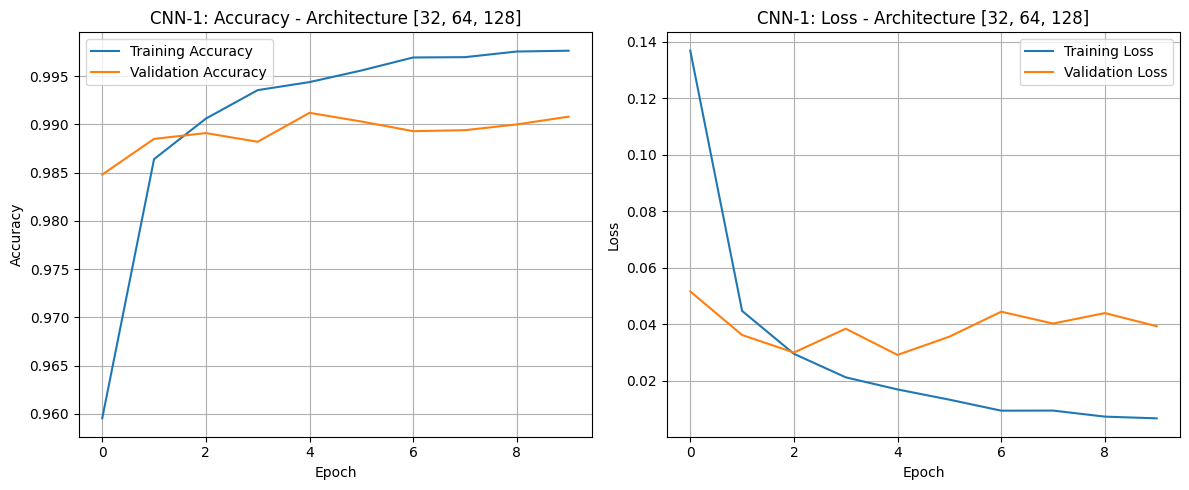


Training CNN-2 with filters [64, 128] ...
  -> Train accuracy: 0.9982
  -> Test accuracy:  0.9869
  -> Parameters:    383,178
  -> Training time: 238.47 seconds



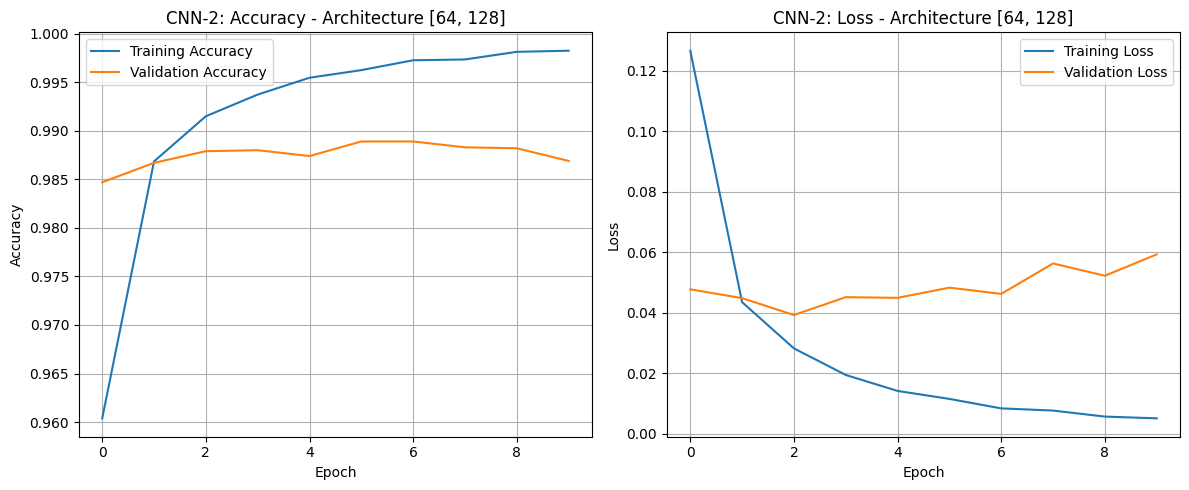


Training CNN-3 with filters [128, 128, 128] ...


In [ ]:
# Run Task 4

cnn_architectures = {
    'CNN-1': [32, 64, 128],
    'CNN-2': [64, 128],
    'CNN-3': [128, 128, 128],
    'CNN-4': [16, 32],
    'CNN-5': [32, 64, 128, 256, 512]
}

base_cnn_model, cnn_df = run_task4(cnn_architectures=cnn_architectures, epochs=10)

df1, df2 = table_mlp_cnn_comparison(mlp_df, cnn_df)

plot_mlp_cnn_comparison(df1, df2)

In [ ]:
# Task 5 Code 


def plot_filters(model, layer_idx, cols):
    layer = model.layers[layer_idx]
    if not isinstance(layer, layers.Conv2D):
        print(f"Layer {layer_idx} is not a convolutional layer.")
        return
    
    filters, _ = layer.get_weights()
    n_filters = filters.shape[-1]
    rows = int(np.ceil(n_filters / cols))
    
    plt.figure(figsize=(cols, rows))
    for i in range(n_filters):
        plt.subplot(rows, cols, i + 1)
        # Average across channels if multi-channel
        filter_img = filters[:, :, 0, i] if filters.shape[2] == 1 else np.mean(filters[:, :, :, i], axis=2)
        filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min() + 1e-7)
        plt.imshow(filter_img, cmap='viridis')
        plt.axis('off')
        plt.title(f'{i+1}', fontsize=8)
    plt.suptitle(f'Filters of {layer.name}')
    plt.tight_layout()
    plt.show()

def plot_activations(model, image, layer_indices, digit_class, cols):
    # Add batch dimension if needed
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)

    for layer_idx in layer_indices:
        layer = model.layers[layer_idx]
        if not isinstance(layer, tf.keras.layers.Conv2D):
            continue

        # Create submodel to extract activations
        input_tensor = tf.keras.Input(shape=(28, 28, 1))
        x = input_tensor
        for l in model.layers[:layer_idx + 1]:
            x = l(x)
        activation_model = tf.keras.models.Model(inputs=input_tensor, outputs=x)

        activations = activation_model.predict(image, verbose=0)

        n_filters = activations.shape[-1]
        rows = int(np.ceil(n_filters / cols))

        plt.figure(figsize=(cols * 2, rows * 2))
        for i in range(n_filters):
            plt.subplot(rows, cols, i + 1)
            activation = activations[0, :, :, i]
    
            activation = (activation - activation.min()) / (activation.max() - activation.min() + 1e-7)
            plt.imshow(activation, cmap='viridis')
            plt.axis('off')
            plt.title(f'Filter {i+1}')
        plt.suptitle(f'Activations of {layer.name} for Digit {digit_class}')
        plt.tight_layout()
        plt.show()

def plot_deep_dream(model, class_indices, input_shape, iterations, learning_rate):
    plt.figure(figsize=(len(class_indices) * 5, 5))
    for i, class_idx in enumerate(class_indices):
        # Start with random noise
        img = tf.random.normal((1,) + input_shape) * 0.1
        img = tf.Variable(img, dtype=tf.float32)
        steps = iterations
        
        # Gradient ascent to maximise class activation
        for _ in range(steps):
            with tf.GradientTape() as tape:
                pred = model(img)
                loss = -tf.math.log(pred[0, class_idx] + 1e-7)
            grads = tape.gradient(loss, img)
            img.assign_sub(grads * learning_rate)
            # Normalise periodically
            if _ % 10 == 0:
                img_np = img.numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-7)
                img.assign(tf.convert_to_tensor(img_np, dtype=tf.float32))
        
        plt.subplot(1, len(class_indices), i + 1)
        dream_img = np.squeeze(img.numpy())
        plt.imshow(dream_img, cmap='viridis')
        plt.title(f"Deep Dream: Digit {class_idx}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def run_task5(model, digit_pairs, dream_iterations=1000, dream_learning_rate=0.001):
    _, X_test_flatened, _, y_test = load_mnist_data()
    
    n_test = X_test_flatened.shape[0]
    x_test = X_test_flatened.reshape(n_test, 28, 28, 1)
    
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    
    conv_layer_indices = [i for i, layer in enumerate(model.layers) if isinstance(layer, layers.Conv2D)]
    
    digit_classes = digit_pairs[0]
    digit_2, digit_9 = digit_classes
    
    y_test_labels = np.argmax(y_test, axis=1)
    digit_2_idx = np.where(y_test_labels == digit_2)[0][0]
    digit_9_idx = np.where(y_test_labels == digit_9)[0][0]
    digit_2_img = x_test[digit_2_idx]
    digit_9_img = x_test[digit_9_idx]
    
    model.build((None, 28, 28, 1))
    
    print("Visualising Filters:")
    for layer_idx in conv_layer_indices:
        plot_filters(model, layer_idx, 16)
    
    print("\nVisualising Activations for Digit '2':")
    plot_activations(model, digit_2_img, conv_layer_indices, digit_class=2, cols=16)
    print("\nVisualising Activations for Digit '9':")
    plot_activations(model, digit_9_img, conv_layer_indices, digit_class=9, cols=16)
    
    print("\nGenerating Deep Dream Images for Digits '2' and '9':")
    plot_deep_dream(model, class_indices=[2, 9], input_shape=(28, 28, 1), iterations=dream_iterations, learning_rate=dream_learning_rate)



In [ ]:
# Run Task 5

digit_pairs = [(2, 9)]

run_task5(base_cnn_model, digit_pairs, dream_iterations=1000, dream_learning_rate=0.001)

In [ ]:
# Task 6 Code

def load_fashion_mnist_data():
    (train_X, train_y_1), (test_X, test_y_1) = keras.datasets.fashion_mnist.load_data()
    train_X = np.expand_dims(train_X / 255.0, axis=-1)  # Normalise to [0,1] and add channel
    test_X = np.expand_dims(test_X / 255.0, axis=-1)

    # Create group labels from individual item labels
    def create_group_label(y):
        group_labels = np.zeros_like(y)
        group_labels[np.isin(y, [5, 7, 9])] = 0  # Shoes
        group_labels[np.isin(y, [3, 6, 8])] = 1  # Gendered
        group_labels[np.isin(y, [0, 1, 2, 4])] = 2  # Uni-Sex
        return group_labels

    train_y_2 = create_group_label(train_y_1)
    test_y_2 = create_group_label(test_y_1)

    train_y_1 = keras.utils.to_categorical(train_y_1, 10)
    test_y_1 = keras.utils.to_categorical(test_y_1, 10)
    train_y_2 = keras.utils.to_categorical(train_y_2, 3)
    test_y_2 = keras.utils.to_categorical(test_y_2, 3)

    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2

def create_single_task_cnn(input_shape, num_classes, task_name):
    model = models.Sequential(name=f"Single_{task_name}")
    # Use Input layer as first layer instead of passing input_shape to Conv2D
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))
    model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))
    model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(3136, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def create_multitask_model(input_shape, lambda_value):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    shared_dense = layers.Dense(3136, activation='relu')(x)

    # Item classification
    task1 = layers.Dense(1024, activation='relu')(shared_dense)
    task1 = layers.Dense(100, activation='relu')(task1)
    task1_output = layers.Dense(10, activation='softmax', name='task1_output')(task1)

    # Group classification
    task2 = layers.Dense(1024, activation='relu')(shared_dense)
    task2 = layers.Dense(100, activation='relu')(task2)
    task2_output = layers.Dense(3, activation='softmax', name='task2_output')(task2)

    model = keras.Model(inputs=inputs, outputs=[task1_output, task2_output])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss={'task1_output': 'categorical_crossentropy', 'task2_output': 'categorical_crossentropy'},
                  loss_weights={'task1_output': float(lambda_value), 'task2_output': 1.0 - float(lambda_value)},
                  metrics={'task1_output': 'accuracy', 'task2_output': 'accuracy'})
    return model

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    else:
        plt.plot(history.history['task1_output_accuracy'], label='Task1 Train Acc')
        plt.plot(history.history['task2_output_accuracy'], label='Task2 Train Acc')
        plt.plot(history.history['val_task1_output_accuracy'], label='Task1 Val Acc')
        plt.plot(history.history['val_task2_output_accuracy'], label='Task2 Val Acc')
    
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
    else:
        plt.plot(history.history['task1_output_loss'], label='Task1 Train Loss')
        plt.plot(history.history['task2_output_loss'], label='Task2 Train Loss')
        plt.plot(history.history['val_task1_output_loss'], label='Task1 Val Loss')
        plt.plot(history.history['val_task2_output_loss'], label='Task2 Val Loss')
    
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def train_single_task_models(train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2, batch_size, epochs):
    model_task1 = create_single_task_cnn(train_X.shape[1:], 10, "Task1_Item")
    model_task2 = create_single_task_cnn(train_X.shape[1:], 3, "Task2_Group")

    print("\nTraining Item Classification Model...")
    start_time = time.time()
    history_task1 = model_task1.fit(train_X, train_y_1, batch_size=batch_size, epochs=epochs, validation_data=(test_X, test_y_1), verbose=0)
    task1_train_time = time.time() - start_time
    task1_test_loss, task1_test_acc = model_task1.evaluate(test_X, test_y_1, verbose=0)
    print(f"Item Classification - Test Accuracy: {task1_test_acc:.4f}")
    
    plot_training_history(history_task1, "Single Task - Item Classification")

    print("\nTraining Group Classification Model...")
    start_time = time.time()
    history_task2 = model_task2.fit(train_X, train_y_2, batch_size=batch_size, epochs=epochs,
                                    validation_data=(test_X, test_y_2), verbose=0)
    task2_train_time = time.time() - start_time
    task2_test_loss, task2_test_acc = model_task2.evaluate(test_X, test_y_2, verbose=0)
    print(f"Group Classification - Test Accuracy: {task2_test_acc:.4f}")
    
    plot_training_history(history_task2, "Single Task - Group Classification")

    return {
        'task1': {
            'model': model_task1, 
            'accuracy': task1_test_acc, 
            'params': model_task1.count_params(), 
            'train_time': task1_train_time,
            'history': history_task1
        },
        'task2': {
            'model': model_task2, 
            'accuracy': task2_test_acc, 
            'params': model_task2.count_params(), 
            'train_time': task2_train_time,
            'history': history_task2
        }
    }

def train_multitask_models(train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2, lambda_values, batch_size, epochs):
    mtl_results = {}
    print("\nTraining MTL Models with different λ values...")
    for lam in lambda_values:
        model = create_multitask_model(train_X.shape[1:], lam)

        start_time = time.time()
        history = model.fit(
            train_X, 
            {'task1_output': train_y_1, 'task2_output': train_y_2},
            batch_size=batch_size, 
            epochs=epochs,
            validation_data=(test_X, {'task1_output': test_y_1, 'task2_output': test_y_2}), 
            verbose=0
        )
        train_time = time.time() - start_time

        test_results = model.evaluate(
            test_X, 
            {'task1_output': test_y_1, 'task2_output': test_y_2},
            verbose=0, 
            return_dict=True
        )
        task1_acc = test_results.get('task1_output_accuracy', 0.0)
        task2_acc = test_results.get('task2_output_accuracy', 0.0)
        print(f"λ = {lam}: Task 1 Acc = {task1_acc:.4f}, Task 2 Acc = {task2_acc:.4f}")
        
        plot_training_history(history, f"Multi-Task Learning (λ={lam})")

        mtl_results[lam] = {
            'model': model, 
            'task1_accuracy': task1_acc, 
            'task2_accuracy': task2_acc,
            'params': model.count_params(), 
            'train_time': train_time,
            'history': history
        }
    return mtl_results

def analyse_results(single_results, mtl_results, lambda_values):
    task1_mtl_accs = [mtl_results[lam]['task1_accuracy'] for lam in lambda_values]
    task2_mtl_accs = [mtl_results[lam]['task2_accuracy'] for lam in lambda_values]
    single_task1_acc = single_results['task1']['accuracy']
    single_task2_acc = single_results['task2']['accuracy']

    # Plot accuracies vs lambda
    plt.figure(figsize=(12, 8))
    plt.plot(lambda_values, task1_mtl_accs, 'o-', linewidth=2, label='MTL Task 1 (Item)')
    plt.plot(lambda_values, task2_mtl_accs, 's-', linewidth=2, label='MTL Task 2 (Group)')
    plt.axhline(single_task1_acc, color='r', linestyle='--', linewidth=2, label=f'Single Task 1: {single_task1_acc:.4f}')
    plt.axhline(single_task2_acc, color='g', linestyle='--', linewidth=2, label=f'Single Task 2: {single_task2_acc:.4f}')
    plt.xlabel('λ (Task 1 Loss Weight)', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('MTL Performance vs. λ', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(lambda_values)
    plt.tight_layout()
    plt.show()
    
    # Model comparison bar chart
    models = ['Single Task 1', 'Single Task 2'] + [f'MTL λ={lam}' for lam in lambda_values]
    task1_accs = [single_task1_acc, 0] + task1_mtl_accs
    task2_accs = [0, single_task2_acc] + task2_mtl_accs
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, task1_accs, width, label='Task 1 (Item) Accuracy', color='skyblue')
    rects2 = ax.bar(x + width/2, task2_accs, width, label='Task 2 (Group) Accuracy', color='lightgreen')
    
    ax.set_ylabel('Test Accuracy', fontsize=12)
    ax.set_title('Model Performance Comparison', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add accuracy values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if height > 0:
                ax.annotate(f'{height:.4f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()
    plt.show()

    # Create a pandas DataFrame for better display
    data = {
        'Model': ['Single Task 1', 'Single Task 2', 'Single Total'] + [f'MTL λ={lam}' for lam in lambda_values],
        'Task 1 Accuracy': [single_task1_acc, 0, 0] + [mtl_results[lam]['task1_accuracy'] for lam in lambda_values],
        'Task 2 Accuracy': [0, single_task2_acc, 0] + [mtl_results[lam]['task2_accuracy'] for lam in lambda_values],
        'Parameters': [single_results['task1']['params'], single_results['task2']['params'], 
                      single_results['task1']['params'] + single_results['task2']['params']] + 
                     [mtl_results[lam]['params'] for lam in lambda_values],
        'Training Time (s)': [int(single_results['task1']['train_time']), 
                             int(single_results['task2']['train_time']), 
                             int(single_results['task1']['train_time'] + single_results['task2']['train_time'])] + 
                            [int(mtl_results[lam]['train_time']) for lam in lambda_values]
    }
    
    summary_df = pd.DataFrame(data)
    
    summary_df['Parameters'] = summary_df['Parameters'].apply(lambda x: f"{x:,}")
    
    display(summary_df)

    # Calculate parameter savings with MTL
    param_savings = single_results['task1']['params'] + single_results['task2']['params'] - mtl_results[0.5]['params']
    print(f"Parameter Savings with MTL: {param_savings:,} ({param_savings/(single_results['task1']['params'] + single_results['task2']['params'])*100:.2f}%)")

    best_lambda = max(lambda_values, key=lambda lam: (mtl_results[lam]['task1_accuracy'] + mtl_results[lam]['task2_accuracy']) / 2)
    best_avg_acc = (mtl_results[best_lambda]['task1_accuracy'] + mtl_results[best_lambda]['task2_accuracy']) / 2
    single_avg_acc = (single_task1_acc + single_task2_acc) / 2
    print(f"Best MTL Avg Accuracy (λ={best_lambda}): {best_avg_acc:.4f} vs. Single Avg: {single_avg_acc:.4f}")

    improves_both = any(mtl_results[lam]['task1_accuracy'] > single_task1_acc and
                        mtl_results[lam]['task2_accuracy'] > single_task2_acc for lam in lambda_values)
    print(f"MTL Improves Both Tasks Simultaneously: {'Yes' if improves_both else 'No'}")

def run_task6(lambda_values, epochs, batch_size=50):
    
    train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2 = load_fashion_mnist_data()

    single_results = train_single_task_models(
        train_X, train_y_1, train_y_2, 
        test_X, test_y_1, test_y_2, 
        batch_size=batch_size, 
        epochs=epochs
    )

    mtl_results = train_multitask_models(
        train_X, train_y_1, train_y_2, 
        test_X, test_y_1, test_y_2,
        lambda_values=lambda_values, 
        batch_size=batch_size, 
        epochs=epochs
    )

    analyse_results(single_results, mtl_results, lambda_values)


In [ ]:
# Run Task 6

lambda_values = [0.0, 0.25, 0.5, 0.75, 1.0]

run_task6(lambda_values, epochs=5)